### 네이버 뉴스 웹크롤링

In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
#검색어
keyword = "유니클로"

In [3]:
#기간 필터

#2018 하반기
fromdate = "20180701"
todate = "20181231"

#2019 상반기
# fromdate = "20190101"
# todate = "20190630"

#2019 하반기
# fromdate = "20190701"
# todate = "20191231"

#2020 상반기
# fromdate = "20200101"
# todate = "20200512"

In [4]:
url = f"https://search.naver.com/search.naver?&where=news&query={keyword}&sm=tab_pge&sort=2&photo=0&field=0&reporter_article=&pd=3&ds={fromdate[:4]}.{fromdate[4:6]}.{fromdate[6:]}&de={todate[:4]}.{todate[4:6]}.{todate[6:]}&docid=&nso=so:da,p:from{fromdate}to{todate},a:all&mynews=0&start=1&refresh_start=0"
get_url = requests.get(url)
soup = BeautifulSoup(get_url.content, "html.parser")
head = soup.select_one("div.section_head span").text
total = int(head[7:-1].replace(",",""))

In [5]:
news_data = [] #기사 내용
news_titles = [] #기사 제목

for start in list(range(1, (total//10)+1, 10)):
    try:
        url = f"https://search.naver.com/search.naver?&where=news&query={keyword}&sm=tab_pge&sort=2&photo=0&field=0&reporter_article=&pd=3&ds={fromdate[:4]}.{fromdate[4:6]}.{fromdate[6:]}&de={todate[:4]}.{todate[4:6]}.{todate[6:]}&docid=&nso=so:da,p:from{fromdate}to{todate},a:all&mynews=0&start={start}&refresh_start=0"
        get_url = requests.get(url)
        soup = BeautifulSoup(get_url.content, "html.parser")
        naver_news = soup.select("dd.txt_inline > a")
        for naver in naver_news:
            try:
                link = naver.get_attribute_list("href")
                news = requests.get(link[0])
                news_soup = BeautifulSoup(news.content, "html.parser")
                news_content = news_soup.select_one("div._article_body_contents")
                news_data.append(news_content.text)
                news_title = news_soup.select_one("div.article_info > h3#articleTitle")
                news_titles.append(news_title.text)
            except:
                pass
    except:
        pass

### 기사 내용(news_data) 워드 클라우드
- Kkma로 명사 추출

In [6]:
from konlpy.tag import Kkma
kkma = Kkma()

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
text = " ".join(news_data)

In [9]:
nouns = " ".join(kkma.nouns(text))

In [10]:
#불용어
stop_w = ["대신", "링크", "5월", "9월", "만큼", "900원", "000원", "모리", "임플란트", "오스템", "300만", "000만", "2018년", "삼성", "카이파샹", "집데꼬", "가지", "우리", "웹툰", "최신", "신동아", "flash", "오류", "우회", "함수", "function", "무단전재", "재배포", "뉴스", "유니클로"]

In [11]:
wordc = WordCloud(background_color="white", max_words=1000, stopwords=stop_w, font_path="C:\Windows\Fonts\malgun.ttf", relative_scaling=0.2)

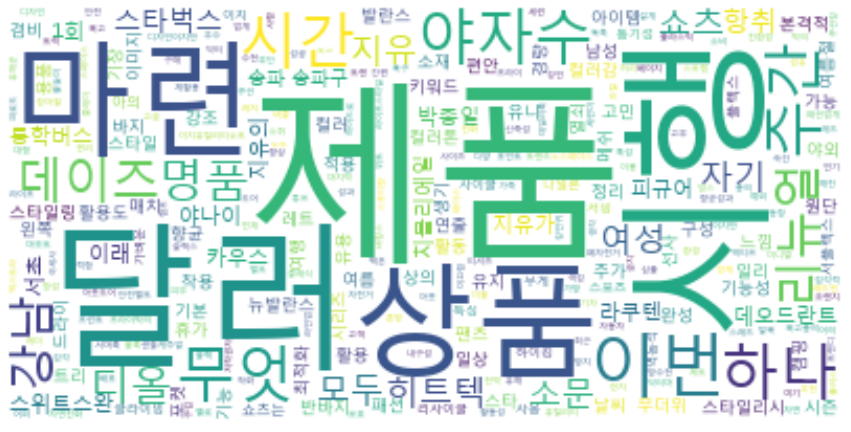

In [12]:
wordc.generate(nouns)

plt.figure(figsize=(15, 10))
plt.imshow(wordc, interpolation="bilinear")
plt.axis("off")
plt.show()

wordc.to_file(f"{keyword}_{fromdate}_{todate}.png")

### 기사 제목(news_title) 연관분석
- Komoran으로 명사 추출
- 사용자 사전파일(userdic.txt) 지정

In [13]:
from konlpy.tag import Komoran
kom = Komoran(userdic = "./userdic.txt")

In [14]:
from apyori import apriori

In [15]:
import pandas as pd

In [16]:
transaction = []

for title in news_titles:
    nouns = kom.nouns(title)
    nouns_filter = filter(lambda word : len(word)>1, nouns)
    nouns_list = list(set(nouns_filter))
    transaction.append(nouns_list)

In [17]:
#연관분석 결과에 따라 최소 지지도, 신뢰도 등 조정
rules = apriori(transaction, min_support=0.03, min_confidence=0.1)
results = list(rules)

In [18]:
results_df = pd.DataFrame(None, columns = ["lhs", "rhs", "support", "confidence", "lift"])
index = 0
for row in results:
    support = row[1]
    ordered_stat = row[2]
    for ordered_item in ordered_stat:
        lhs = " ".join(x.strip() for x in ordered_item[0])
        rhs = " ".join(x.strip() for x in ordered_item[1])
        confidence = ordered_item[2]
        lift = ordered_item[3]
        results_df.loc[index] = [lhs, rhs, support, confidence, lift]
        index = index + 1

In [19]:
#전제조건: keyword
#높은 향상도를 가지는 연관규칙 15건 추출
results_df.loc[results_df.lhs == keyword].sort_values(by=["lift"], ascending=False).head(15)

,lhs,rhs,support,confidence,lift
79,유니클로,황제,0.064748,0.18,2.78
77,유니클로,홍보대사,0.064748,0.18,2.78
289,유니클로,홍보대사 황제 테니스,0.043165,0.12,2.78
262,유니클로,홍보대사 황제 로저 페더러,0.035971,0.10,2.78
248,유니클로,황제 테니스 로저 페더러,0.043165,0.12,2.78
234,유니클로,홍보대사 테니스 로저 페더러,0.043165,0.12,2.78
193,유니클로,홍보대사 황제,0.043165,0.12,2.78
187,유니클로,황제 테니스,0.064748,0.18,2.78
181,유니클로,홍보대사 테니스,0.050360,0.14,2.78
140,유니클로,황제 로저 페더러,0.043165,0.12,2.78
